多分类逻辑回归问题的极大似然解法
=========

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch

np.random.seed(0xff)
torch.manual_seed(0xff)
torch.__version__

'1.3.1'

前面已经介绍了二分类问题的解法，如果有$K>2$个类别的话，如何处理呢？

课件中介绍了一种比较神奇的建模方法，我觉得比较有趣，所以用代码来实现一下。

先来看数据：

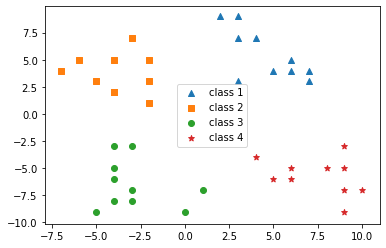

In [2]:
def genpoint(x, y):
    return (np.random.randint(-3, 4) + x, np.random.randint(-3, 4) + y)

class1_points = np.array([genpoint(5, 6) for _ in range(10)])
class2_points = np.array([genpoint(-5, 4) for _ in range(10)])
class3_points = np.array([genpoint(-2, -6) for _ in range(10)])
class4_points = np.array([genpoint(7, -6) for _ in range(10)])

test_x = np.array([genpoint(5, 6), genpoint(-5, 4), genpoint(-2, -6), genpoint(7, -6)])
test_y = np.array([1, 2, 3, 4])

plt.scatter(class1_points[:, 0], class1_points[:, 1], marker='^', label='class 1')
plt.scatter(class2_points[:, 0], class2_points[:, 1], marker='s', label='class 2')
plt.scatter(class3_points[:, 0], class3_points[:, 1], marker='o', label='class 3')
plt.scatter(class4_points[:, 0], class4_points[:, 1], marker='*', label='class 4')
plt.legend()
plt.show()

在这里我们假设一共有$K=4$类点，它们的分布如上图。

对于多分类问题，一个办法是转化为$K$个二分类问题，就是对每个类别做一个"输入$x$是否属于该类别"的分类器。但是这个办法存在的问题一是正例和负例的不均衡，另一个问题是如何将$K$个二分类器的答案合并到一起。

课件中介绍了一种巧妙的方法。首先我们选择一个轴类别(pivot)，然后用轴类别的概率来表示其他$K-1$个类别的概率。

在这里，我们选择最后一个类别(第$K$类)作为轴类别，然后设定其他类别的概率关于第$K$类别的关系：

$$
\begin{align*}
log \frac{P(y=1|x,w)}{P(y=K|x,w)} & = w^{(1)T} x \\
log \frac{P(y=2|x,w)}{P(y=K|x,w)} & = w^{(2)T} x \\
\vdots \\
log \frac{P(y=K-1|x,w)}{P(y=K|x,w)} & = w^{(K-1)T} x
\end{align*}
$$

其中，$x$是一个输入样例，$P(y=1|x,w)$表示在输入为$x$，参数为$w$的情况下，该输入属于第$1$类别的概率。$w$是我们分类器所用到的参数，包含$K-1$个列向量，$w^{(1)}$表示参数$w$的第$1$个列向量，即$w = [w^{(1)}, w^{(2)}, \cdots, w^{(K-1)}]$。$w^{(1)T}$表示$w^{(1)}$的转置。

对上面的等式两边同时取对数，并将$P(y=K|x,w)$移到右边，可得：

$$
\begin{align*}
P(y=1|x,w) & = P(y=K|x,w) \times e^{w^{(1)T} x} \\
P(y=2|x,w) & = P(y=K|x,w) \times e^{w^{(2)T} x} \\
\vdots \\
P(y=K-1|x,w) & = P(y=K|x,w) \times e^{w^{(K-1)T} x}
\end{align*}
$$

然后，由于同一个输入属于$K$个类别的概率之和应该等于$1$，因此有：

$$
\begin{align*}
\sum_{l=1}^K P(y=l|x,w) & = \sum_{l=1}^{K-1} \left( P(y=K|x,w) \times e^{w^{(l)T} x} \right) + P(y=K|x,w) \\
    & = P(y=K|x,w) \times \left( 1 + \sum_{l=1}^{K-1} e^{w^{(l)T} x} \right) \\
    & = 1
\end{align*}
$$

所以可以计算出第$K$类的概率应该为：

$$
P(y=K|x,w) = \frac{1}{1 + \sum_{l=1}^{K-1} e^{w^{(l)T} x}}
$$

将此概率代回前$K-1$类别的概率公式，可以得到每个类别的概率：

$$
P(y=i|x,w) = \frac{e^{w^{(i)T} x}}{1 + \sum_{l=1}^{K-1} e^{w^{(l)T} x}}
$$

到此，我们就拥有了一个可以根据输入$x$和参数$w$，计算该输入属于每个类别的概率的模型。然后可以计算出log-likelihood:

$$
L(w) = \sum_{i=1}^{K} \sum_{x \in samples(i)} log(P(y=i|x,w))
$$

其中$samples(i)$是属于第$i$类的点的集合。

$L(w)$的完整公式非常复杂，对其进行求导是非常困难的。万幸的是我们只需要使用pytorch构建出计算图，它可以自动帮我们求导。

代码中用到了几个技巧，虽然会增加一些计算两，但是可以大大简化我们的编程复杂度。

技巧一是我们可以添加一个“假”的参数$w^{(K)}$，参数$w^{(K)}$不可学习并且永远都等于$0$。有了这个假的参数，每个类别的概率公式可以统一为：

$$
P(y=i|x,w) = \frac{e^{w^{(i)T} x}}{\sum_{l=1}^{K} e^{w^{(l)T} x}}
$$

这是由于$w^{(K)}=0$，因此$e^{w^{(K)T} x}$永远等于$1$。通过这种方式我们将所有类别的概率公式统一了。

技巧二是使用了一个mask技巧，详见代码（实际上类似机器学习中的one-hot向量）。

In [3]:
K = 4 # 总共4个类别

x = np.concatenate([
    np.concatenate([class1_points, np.ones((len(class1_points), 1))], axis=1),
    np.concatenate([class2_points, np.ones((len(class2_points), 1))], axis=1),
    np.concatenate([class3_points, np.ones((len(class3_points), 1))], axis=1),
    np.concatenate([class4_points, np.ones((len(class4_points), 1))], axis=1)
]).T # 构造输入，添加一个值为1的维度（解决常数项）
print('x[:, 0] is', x[:, 0]) # x的每个列向量是一个输入

y = np.concatenate([
    np.repeat(np.eye(K)[0][np.newaxis, :], len(class1_points), axis=0),
    np.repeat(np.eye(K)[1][np.newaxis, :], len(class2_points), axis=0),
    np.repeat(np.eye(K)[2][np.newaxis, :], len(class3_points), axis=0),
    np.repeat(np.eye(K)[3][np.newaxis, :], len(class4_points), axis=0),
]).T
print('y[:, 0] is', y[:, 0]) # y的每个列向量是一个one-hot向量，对应类别那一维为1

x = torch.from_numpy(x).float()
y = torch.from_numpy(y).float()

x[:, 0] is [5. 4. 1.]
y[:, 0] is [1. 0. 0. 0.]


设置输入输出数据

In [4]:
w = torch.rand((3, K-1), requires_grad=True).float() # 设置参数，每个列向量表示一个参数
w

tensor([[0.7677, 0.0509, 0.0971],
        [0.9270, 0.4893, 0.6929],
        [0.1402, 0.1885, 0.2482]], requires_grad=True)

In [5]:
learning_rate = 0.001
steps = 10000

设置学习相关的参数

In [6]:
for step in range(steps):
    w.requires_grad_(True) # 需要计算w的梯度
    ww = torch.cat([w, torch.zeros(3, 1)], dim=1) # 最后一个参数始终为0
    
    output = torch.exp(torch.mm(ww.T, x))
    output = output / torch.sum(output, dim=0)
    output = torch.sum(output * y, dim=0) # 计算每个数据被正确的概率

    L = torch.sum(torch.log(output)) # 计算log-likelihood
    L.backward()
    
    w = w + learning_rate * w.grad
    w = w.detach()
    
    if step % 1000 == 0:
        print(f'step = {step}, L = {L.item()}, output = {output.detach().numpy()[:4]}')

step = 0, L = -73.45039367675781, output = [0.979637  0.9798994 0.9928874 0.9947305]
step = 1000, L = -0.48518943786621094, output = [0.9982991  0.99596524 0.99536735 0.99894625]
step = 2000, L = -0.2683483064174652, output = [0.9990372 0.9982565 0.9965726 0.9993309]
step = 3000, L = -0.18784287571907043, output = [0.9993243 0.9989587 0.9972493 0.9995122]
step = 4000, L = -0.1452285796403885, output = [0.99948084 0.9992845  0.99768674 0.9996181 ]
step = 5000, L = -0.1186867356300354, output = [0.9995797  0.9994677  0.99799526 0.99968743]
step = 6000, L = -0.10050812363624573, output = [0.99964803 0.99958307 0.9982258  0.9997363 ]
step = 7000, L = -0.08725056052207947, output = [0.99969804 0.9996616  0.9984054  0.9997726 ]
step = 8000, L = -0.07713961601257324, output = [0.99973613 0.9997179  0.99854976 0.9998005 ]
step = 9000, L = -0.06916699558496475, output = [0.9997661  0.99975985 0.99866843 0.9998227 ]


在迭代了这么多轮之后，log-likelihood已经收敛到非常小，输出的概率值也精确了

In [7]:
# 将参数导出成numpy数组
w = np.concatenate([w.numpy(), np.zeros((3, 1))], axis=1)

# 准备测试数据
test_x = np.concatenate([test_x, np.ones((len(test_x), 1))], axis=1).T

In [8]:
output = np.exp(np.dot(w.T, test_x))
output = output / np.sum(output, axis=0) # 计算每个类别概率

classes = np.argmax(output, axis=0)
probability = np.max(output, axis=0)
print(f'output class is {classes} with probability {probability}, tree class is {test_y - 1}')

output class is [0 1 2 3] with probability [0.99997939 0.99999817 0.99985336 0.98700659], tree class is [0 1 2 3]


可以看到，在测试数据上，我们的分类器也能够正确的进行分类。

如果读者对机器学习有一些了解的话，可以看到，当我们添加了参数$w^{(K)}=0$之后，每个类别的概率其实是一个softmax函数。实际上在本例中也可以不指定$w^{(K)}=0$，而是使它成为一个可以学习的参数，同样可以得到一个非常好的分类器。